### 1) A visualisation of a meridian on a map running through Olsztyn, a town located in Poland

In [1]:
import pandas as pd
import geopandas as gd

from datetime import date

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
plt.style.use("fivethirtyeight")

from astral import LocationInfo
import datetime
from astral.sun import sun
import astral


In [2]:
# in geography and geodesy, a meridian is the locus connecting points of equal longitude
# we will create a list of lattitudes ranging from -89 to 89
lat, long = [53.778 , 20.4801]

latitudes = list(range(-89, 90, 1))
print(latitudes)

[-89, -88, -87, -86, -85, -84, -83, -82, -81, -80, -79, -78, -77, -76, -75, -74, -73, -72, -71, -70, -69, -68, -67, -66, -65, -64, -63, -62, -61, -60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]


In [3]:
# with a list of latitudes, we can create a new Pandas dataframe with coordinates along 20.4801 longitude
df = pd.DataFrame({
    'Latitude': latitudes,
    'Longitude': [long for x in range(len(latitudes))]
    })

display(df.head(5))

,Latitude,Longitude
0,-89,20.4801
1,-88,20.4801
2,-87,20.4801
3,-86,20.4801
4,-85,20.4801


In [4]:
# converting dataframe to geodataframe
points = gd.GeoDataFrame(
    df, geometry=gd.points_from_xy(df.Longitude, df.Latitude)).set_crs("EPSG:4326")

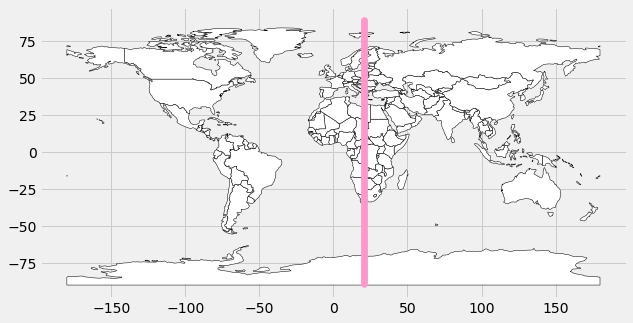

In [5]:
world = gd.read_file('naturalearth_lowres')

ax = world.plot(
    color='white', edgecolor='black', figsize=(10,5))

points.plot(ax=ax, color='#ff99cc')

plt.savefig('20.4801 -meridian.png', bbox_inches='tight')

plt.show()

### 2) Obtaining day-length for each point along the meridian on a given day
- output is saved in a dataframe
- time data is given as timedelta and float

In [6]:
# method returning the length of day as timedelta including errors
df = points.copy()
df['date'] = date.today()
display(df.head(2))

def get_length(row):
    lat = row['Latitude']
    long = row['Longitude']
    info = None
    try:
        olsztyn = LocationInfo('20.4801 meridian', 'region', 'timezone/name', lat, long)
        s = sun(olsztyn.observer, date=datetime.date(2022, 12, 28))
        day_lenght = s["sunset"] - s["sunrise"]
        info = day_lenght
    except ValueError as e:
        info = e
    return info
   

df['day_timedelta'] = df.apply(get_length, axis=1)

,Latitude,Longitude,geometry,date
0,-89,20.4801,POINT (20.48010 -89.00000),2022-12-29
1,-88,20.4801,POINT (20.48010 -88.00000),2022-12-29


In [7]:
# value errors returned by Astral
unique_errors = set()
for error in list(df['day_timedelta'].unique()):
    if isinstance(error, Exception) == True:
        unique_errors.add(str(error))

for error in unique_errors:
    print(error)

Sun never reaches 6 degrees below the horizon, at this location.
Sun is always below the horizon on this day, at this location.


In [8]:
# method returning the length of day as timedelta
# places where the sun is always below or never always above horizon get null values in 'day_timedelta'
df = points.copy()
df['date'] = date.today()
display(df.head(2))

def get_length(row):
    lat = row['Latitude']
    long = row['Longitude']
    info = None
    try:
        olsztyn = LocationInfo('Miasto olsztyn', 'region', 'timezone/name', lat, long)
        s = sun(olsztyn.observer, date=datetime.date(2022, 12, 28))
        day_lenght = s["sunset"] - s["sunrise"]
        info = day_lenght
    except ValueError as e:
        # value error when the sun does not set on this latitude or is under the horizon 
        # then the function returns a null value
        info = None
    return info
   

df['day_timedelta'] = df.apply(get_length, axis=1)
df['day_float'] = ((df['day_timedelta'].dt.total_seconds() / 60) /60)

,Latitude,Longitude,geometry,date
0,-89,20.4801,POINT (20.48010 -89.00000),2022-12-29
1,-88,20.4801,POINT (20.48010 -88.00000),2022-12-29


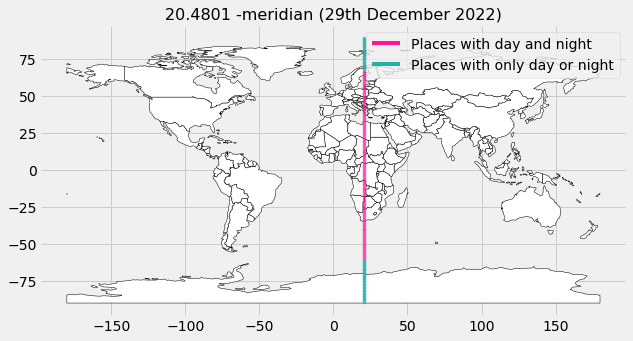

In [13]:
# selecting null values in the 'day_timedelta' column
data = df.copy()
null_values = data[data['day_timedelta'].isnull()]

# dropping null values in the 'day_timedelta' column
data = data.dropna(subset=['day_timedelta'])

legend_elements = [
    Line2D([0], [0], label='Places with day and night', color='deeppink'),
    Line2D([0], [0], label='Places with only day or night', color='lightseagreen')
]

# displaying data
ax = world.plot(
    color='white', edgecolor='black', figsize=(10,5))

data.plot(ax=ax, color='deeppink', alpha=0.4, markersize=10)
null_values.plot(ax=ax, color='lightseagreen', alpha=0.6, markersize=10)

ax.legend(handles=legend_elements)
plt.title('20.4801 -meridian (29th December 2022)', fontsize=16)
plt.savefig('20.4801 -meridian - 29th December 2022.png', bbox_inches='tight')
plt.show()

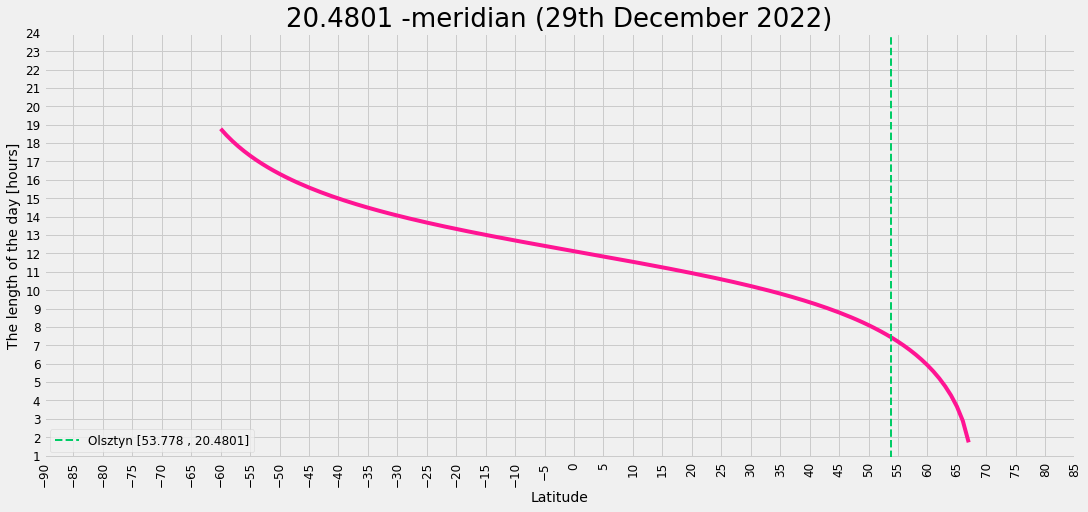

In [35]:

fig, ax = plt.subplots(figsize=(15,7), constrained_layout=True)

legend_elements = [
    Line2D([0], [0], label='Olsztyn [53.778 , 20.4801]', color="#00cc66", ls='--', linewidth = 2),

]

ax.plot(df['Latitude'],df['day_float'], color='deeppink')
ax.axvline(53.778, color="#00cc66", ls='--', linewidth = 2)

ax.legend(handles=legend_elements, loc='lower left', fontsize=12 )
                          
ax.set_xticks(list(range(-90, 90, 5)))
ax.set_yticks(list(range(1,25, 1)))

plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('The length of the day [hours]', fontsize=14)
plt.title('20.4801 -meridian (29th December 2022)', fontsize=26)

plt.savefig('20.4801-meridian - 29th December 2022 Plot.png', bbox_inches='tight')
plt.show()

In [44]:
data['day_float'].describe()

count    128.000000
mean      11.718896
std        3.370917
min        1.719734
25%        9.790652
50%       11.917820
75%       13.920171
max       18.778494
Name: day_float, dtype: float64

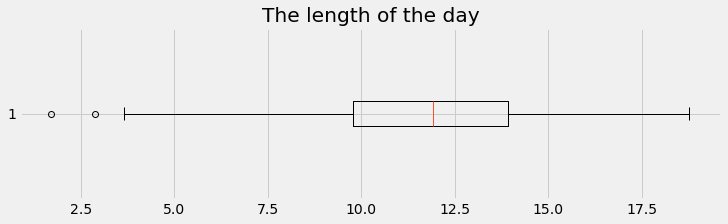

In [49]:
fig, ax = plt.subplots(figsize=(10,3), constrained_layout=True)
ax.set_title('The length of the day')
ax.boxplot(list(data['day_float']), vert=False)
plt.show()